## Попробуйте изменить параметры нейронной сети, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) или любым любимым временным рядом так, чтобы улучшить её точность. Приложите анализ

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
%matplotlib inline

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import utils
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler

Считаем данные из файла со значениями количества пассажиров.

In [3]:
df = pd.read_csv('../Manuals/lesson_5/airline-passengers.csv')
df.index = df.Month
df.reset_index(drop=True, inplace=True)

Посмотрим, что из себя представляют данные датасета.

In [4]:
df.head(3)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [5]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


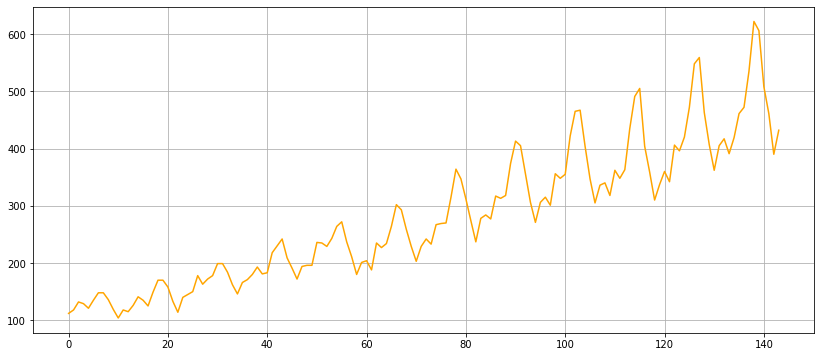

In [6]:
plt.figure(figsize=(14,6))
plt.plot(df['Passengers'], color='Orange')
plt.grid()
plt.show()

Возьмем первые 100 значений для тренировки. Значение колонки Month приведем к числовому порядковому значению месяца.

In [7]:
df_train = df.iloc[:100, :].copy()

df_train.loc[:, 'Month'] = pd.to_datetime(df_train.Month)
df_train.loc[:, 'Month'] = df_train.Month.dt.month

In [8]:
df_train.head(3)

,Month,Passengers
0,1,112
1,2,118
2,3,132


Разделим выборку на x и y и создадим, подготовим 5 батчей, в каждом на входе будет по 4 значения.

In [9]:
X_train, y_train = df_train, df_train.Passengers

In [10]:
xLEN = 4
batch_size = 5

train_data = keras.preprocessing.timeseries_dataset_from_array(
    X_train.iloc[:-xLEN,:],
    y_train[xLEN:],
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size
)

In [11]:
for batch in train_data.take(2):
    inputs, targets = batch

Теперь займемся тестовой выборкой. Она будет состоять из значений, которые идут после сотого. Проделаем все те же манипуляции, что и с тестовой выборкой.

In [12]:
df_test = df_train = df.iloc[100:, :].copy()
df_test.loc[:, 'Month'] = pd.to_datetime(df_test.Month)
df_test.loc[:, 'Month'] = df_test.Month.dt.month

df_test.head(3)

,Month,Passengers
100,5,355
101,6,422
102,7,465


In [13]:
X_test, y_test = df_test, df_test.Passengers

In [14]:
X_test.head(3)

,Month,Passengers
100,5,355
101,6,422
102,7,465


Подготовим данные для обучения и валидации. Для этого возьмем копию тренировочного набора данных.

In [15]:
data = X_train.copy()

In [16]:
data.head(3)

,Month,Passengers
0,1,112
1,2,118
2,3,132


Нормализуем данные.

In [17]:
val_split = 20
scaler = StandardScaler()
data_v = scaler.fit(data[:val_split])
 
data_f = pd.DataFrame(scaler.transform(data))

In [18]:
data_f.head(3)

,0,1
0,-1.470906,-1.181840
1,-1.157947,-0.836777
2,-0.844989,-0.031631


Создаем данные для обучения.

In [19]:
# признаки для обучения (колонки)
channelIndexes = [0, 1]

# сколько точек для теста
valLen = 20

# смещение от тренировок
bias = 3

In [20]:
# вычислим точку разделения ряда на тесты и тренировку
train_split = data_f.shape[0] - valLen - bias
train_split

# разделим выборку на тренировочную и валидационную
train_data = data_f.iloc[:train_split, channelIndexes]
val_data = data_f.iloc[train_split+bias:, channelIndexes]

In [21]:
train_data.head(3)

,0,1
0,-1.470906,-1.181840
1,-1.157947,-0.836777
2,-0.844989,-0.031631


In [22]:
val_data.head(3)

,0,1
80,1.032764,10.320251
81,1.345723,8.134854
82,1.658681,6.006967


Выборки сформированы верно. Как и планировалось, валидация начинается с 80й точки. Теперь сформируем параметры для генерации выборки.

In [23]:
# шаг для построения обучающих примеров
step = 1

# длина данных, на основе которых мы будем учить
past = xLEN

# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
epochs = 10

Зададим части для обучения и проверки.

In [24]:
Chanel_numb = len(channelIndexes)

start = xLEN + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLEN+1,:] # сдвиг по времени (закончим чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLEN-1:,1].values  # сдвиг по времени (начнем чуть позднее)

sequence_length = int(xLEN / step)
x_end = len(val_data) - xLEN - future 
label_start = len(train_data)+bias+xLEN + future +1

xVal_df = val_data.iloc[:-future-xLEN+1,:] # сдвиг по времени (закончим чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLEN-1:,1].values  # сдвиг по времени (начнем чуть позднее)

In [25]:
print(xTrain.shape)
print(yTrain.shape)

print(xVal.shape)
print(yVal.shape)

(73, 2)
(73,)
(16, 2)
(16,)


Посмотрим на результаты на графике.

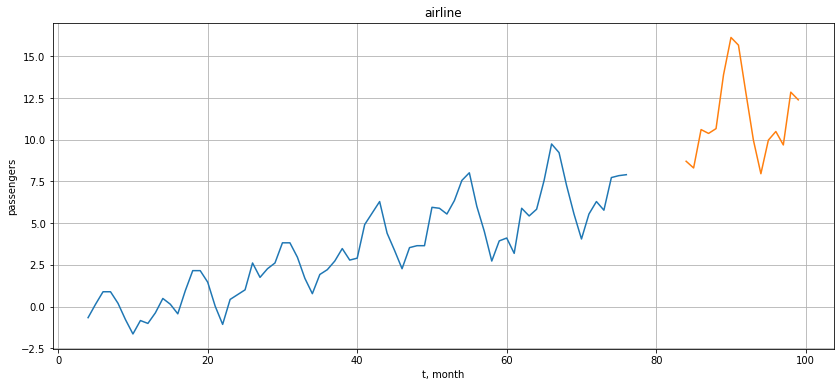

In [26]:
plt.figure(figsize=(14,6))
plt.plot(data_f.index[xLEN:yTrain.shape[0]+xLEN], yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+bias+future+2*xLEN-1:], yVal[:])
plt.grid()
plt.xlabel('t, month')
plt.ylabel('passengers')
plt.title('airline')
plt.show()

Используем механизм формирования пакетов для обучения.

In [27]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size,
)

In [28]:
for batch in dataset_val.take(2):
    inputs, targets = batch

In [29]:
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (5, 4, 2)
Target shape: (5,)


In [30]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

Создадим сеть:  LSTM слои + Conv1D + Dense слой.

In [31]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True"))

model.add(Conv1D(64, 3, activation="linear"))

model.add(Flatten())

model.add(Dense(3, activation="linear"))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 64)             17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 64)             33024     
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 64)             12352     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 62,919
Trainable params: 62,919
Non-trainable params: 0
____________________________________________________

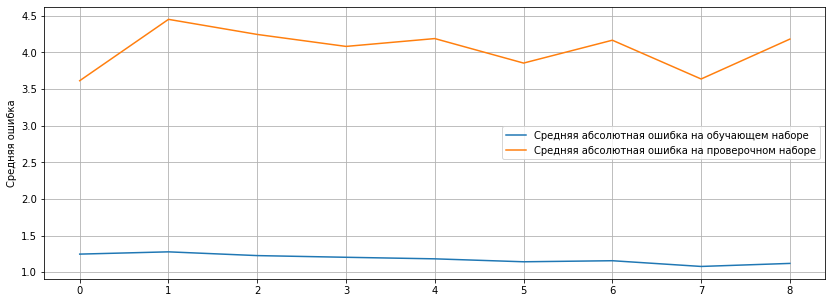

In [32]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    verbose=0
)

plt.figure(figsize=(14, 5))

plt.plot(history.history['mae'][1:], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], label='Средняя абсолютная ошибка на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()

plt.show()

In [33]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

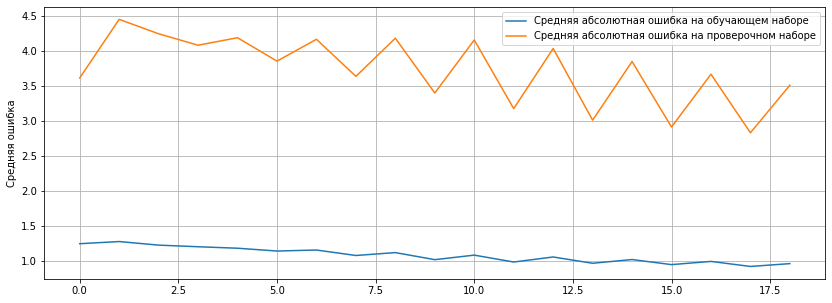

In [34]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    verbose=0
)

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.figure(figsize=(14, 5))

plt.plot(hist_train[1:], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], label='Средняя абсолютная ошибка на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()

plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [35]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [36]:
yVal.shape, predVal.shape

((16,), (13,))

Валидация:

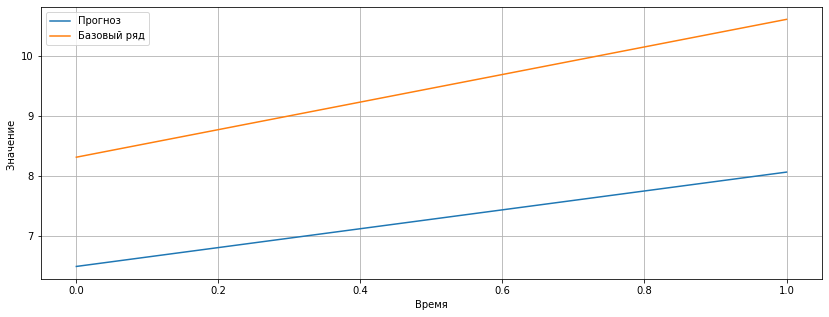

In [37]:
start = 1
step = 2

plt.figure(figsize=(14, 5))

plt.plot(predVal[start:start+step], label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], label='Базовый ряд')

plt.xlabel('Время')
plt.ylabel('Значение ')

plt.grid()
plt.legend()
plt.show()

Тренировочные даннные:

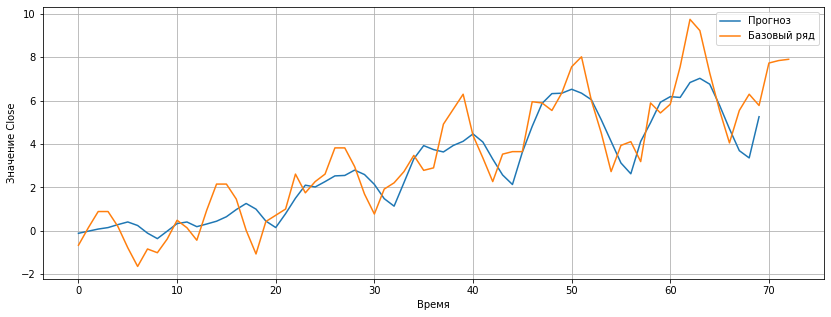

In [38]:
start = 0

plt.figure(figsize=(14,5))

plt.plot(pred[start:train_split], label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], label='Базовый ряд')

plt.xlabel('Время')
plt.ylabel('Значение Close')

plt.grid()
plt.legend()
plt.show()

Проверяем качество модели:
- оценим по лаговой корреляции рядов a, b;
- если наибольшая корреляция с лагом 0, то отлично;
- есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).


In [39]:
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()
  
    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

In [40]:
start = 1
step = 3

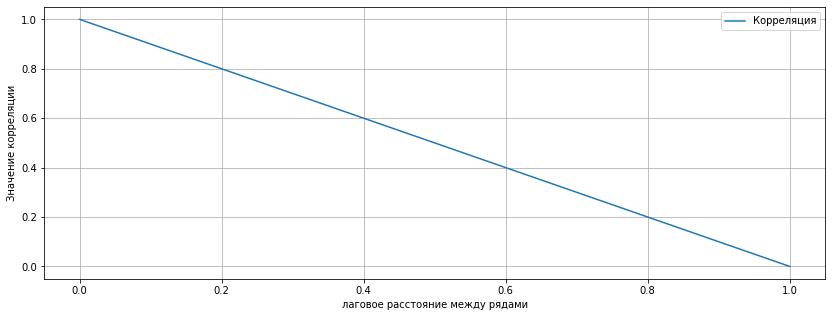

In [41]:
corr = []
h = 0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 

# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(step-1):
    corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))

plt.figure(figsize=(14, 5))
plt.plot(corr, label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')

plt.grid()
plt.legend()
plt.show()

## Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku 
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers

Разбор текста, токенизация

In [43]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(
                num_words=10000,
                filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'",
                lower=True, 
                split=' ',
)

data = open('../Manuals/lesson_5/alice_in_wonderland.txt').read()

#Читаем текст
corpus = data.lower().split("\n")

In [44]:
corpus[40:60]

['chapter i. down the rabbit-hole',
 '',
 'alice was beginning to get very tired of sitting by her sister on the',
 'bank, and of having nothing to do: once or twice she had peeped into the',
 'book her sister was reading, but it had no pictures or conversations in',
 'it, ‘and what is the use of a book,’ thought alice ‘without pictures or',
 'conversations?’',
 '',
 'so she was considering in her own mind (as well as she could, for the',
 'hot day made her feel very sleepy and stupid), whether the pleasure',
 'of making a daisy-chain would be worth the trouble of getting up and',
 'picking the daisies, when suddenly a white rabbit with pink eyes ran',
 'close by her.',
 '',
 'there was nothing so very remarkable in that; nor did alice think it so',
 'very much out of the way to hear the rabbit say to itself, ‘oh dear!',
 'oh dear! i shall be late!’ (when she thought it over afterwards, it',
 'occurred to her that she ought to have wondered at this, but at the time',
 'it all seemed qu

Выполним токенизацию и кодирование

In [45]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [46]:
token_list

[3397, 4, 367, 1307, 3398, 4, 278, 38, 497, 622]

In [47]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         22, 444,  31,  24,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22,
        444,  31,  24,   1, 150],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,
         31,  24,   1, 150,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,  31,
         24,   1, 150,   6, 707]], dtype=int32)

In [48]:
label.shape

(28231, 3399)

Создаем нейросеть, зададим критерий останова.

In [49]:
callback = EarlyStopping(monitor='val_loss', patience=10) # создаем обратный вызов - calback - тут "Ранний останов"

In [50]:
model = Sequential()

model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  
# вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)),
# на выход строим вектор из n (тут 256) координат - он плотный.

model.add(LSTM(128))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 256)           870144    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1699)              219171    
_________________________________________________________________
dense_3 (Dense)              (None, 3399)              5778300   
Total params: 7,064,735
Trainable params: 7,064,735
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(predictors,
                    label,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[callback],
                    verbose=0)

Посмотрим на графики потерь и точности.

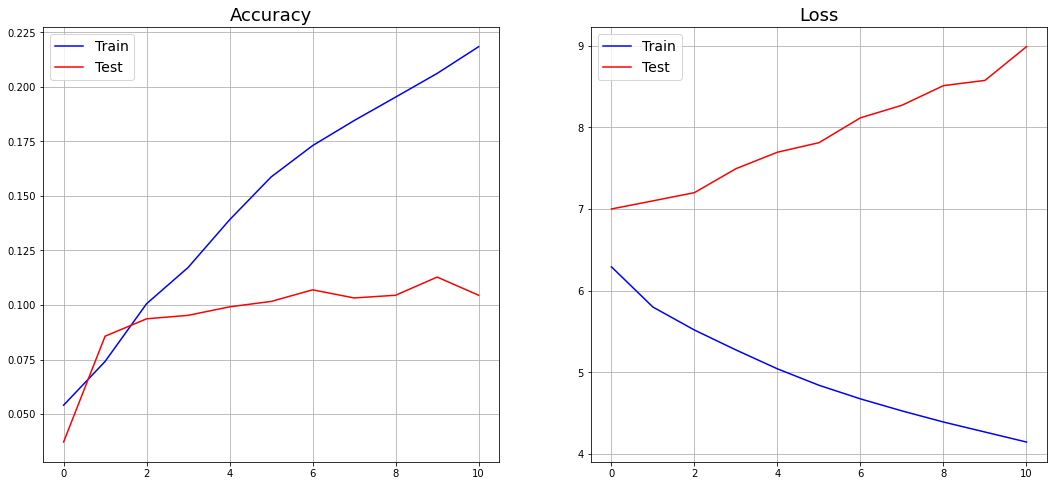

In [52]:
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.plot(epochs, acc, 'b', label='Train')
ax1.plot(epochs, acc_v, 'r', label='Test')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=14)
ax1.grid()

ax2.plot(epochs, loss, 'b', label='Train')
ax2.plot(epochs, loss_v, 'r', label='Test')
ax2.set_title('Loss', fontsize=18)
ax2.legend(fontsize=14)
ax2.grid()

plt.show()

Протестируем генератор.

In [53]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 15

# строим последовательность + новое предсказание  
for _ in range(next_words):
    # текущая последовательность (токенизация и дополнение)
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""

    # добавим новое слово в последовательность
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    
    seed_text += " " + output_word
print(seed_text)

[360, 69, 11, 1311, 80, 107, 841]
[360, 69, 11, 1311, 80, 107, 841, 2]
[360, 69, 11, 1311, 80, 107, 841, 2, 9]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5, 32, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5, 32, 32, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5, 32, 32, 32, 108]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5, 32, 32, 32, 108, 10]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5, 32, 32, 32, 108, 10, 5]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5, 32, 32, 32, 108, 10, 5, 32]
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 1, 87, 10, 5, 32, 32, 32, 108, 10, 5, 32, 32]
Help me Obi Wan Kenobi, you're my only hope ’ said the gryphon in a little little little voice in a little little li

Построим график распределения вероятностей по словам.

In [54]:
y_p=model.predict(token_list)

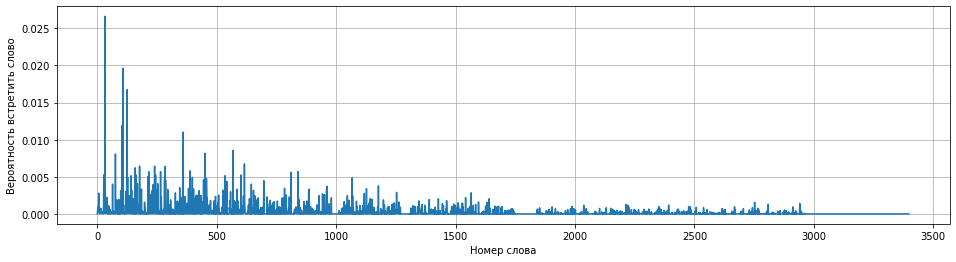

In [55]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])

plt.xlabel('Номер слова')
plt.ylabel('Вероятность встретить слово')

plt.grid()
plt.show()

In [56]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([], dtype=int64)

In [57]:
for i,ind in enumerate(ind_prob.tolist()):
    print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

In [58]:
# Начальная строка
seed_text = "She is my girl, I see in"
next_words = 15

# Строим последовательность плюс новое предсказание
for _ in range(next_words):
    
    # текущая последовательность (токенизация и дополнение)
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    output_word = ""
    y_p=model.predict(token_list)
    y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
    predicted_ind = np.argmax(y_predict,axis = 1)
    
    # Добавим новое слово в последовательность
    for word, index in tokenizer.word_index.items():
        if index == predicted_ind:
            output_word = word
            break
    seed_text += " " + output_word
    
print(seed_text)

[7, 31, 80, 840, 15, 65, 10]
[7, 31, 80, 840, 15, 65, 10, 5]
[7, 31, 80, 840, 15, 65, 10, 5, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12, 77]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12, 77, 10]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12, 77, 10, 5]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12, 77, 10, 5, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12, 77, 10, 5, 32, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12, 77, 10, 5, 32, 32, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12, 77, 10, 5, 32, 32, 32, 125]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 359, 2, 3, 12, 77, 10, 5, 32, 32, 32, 125, 3]
She is my girl, I see in a little deal ’ and alice began in a little little little tone and alice


Построим более сложную модель.

In [59]:
model2 = Sequential()

model2.add(Embedding(total_words, 256, input_length=max_sequence_len-1))

model2.add(LSTM(128, return_sequences="True"))
model2.add(LSTM(64, return_sequences="True"))
model2.add(Conv1D(32, 3, activation="linear"))
model2.add(Conv1D(16, 1, activation="linear"))
model2.add(Dropout( 0.2))
model2.add(Flatten())
model2.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(total_words, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 256)           870144    
_________________________________________________________________
lstm_3 (LSTM)                (None, 17, 128)           197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 17, 64)            49408     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            6176      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 16)            528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 240)              

In [60]:
history = model2.fit(predictors,
                    label,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[callback],
                    verbose=0)

Визуализируем метрики

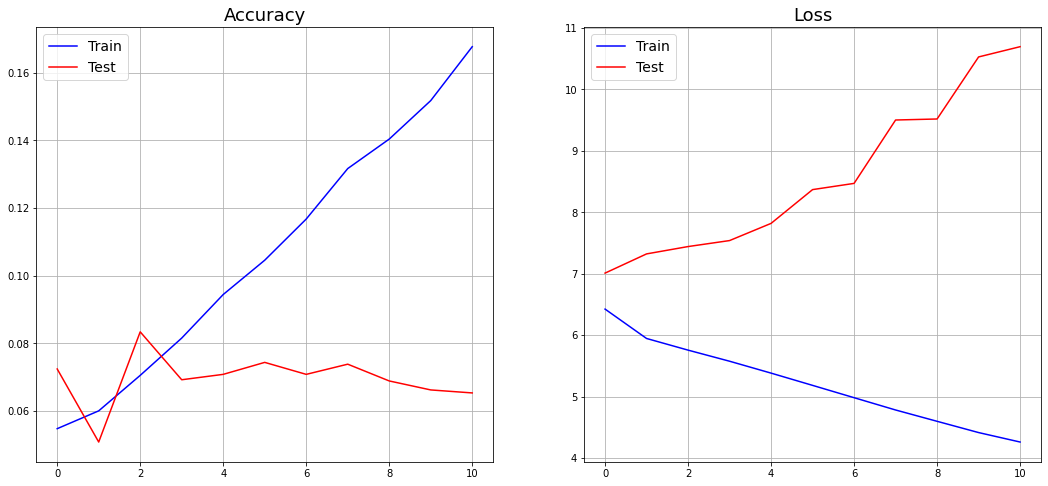

In [61]:
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.plot(epochs, acc, 'b', label='Train')
ax1.plot(epochs, acc_v, 'r', label='Test')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=14)
ax1.grid()

ax2.plot(epochs, loss, 'b', label='Train')
ax2.plot(epochs, loss_v, 'r', label='Test')
ax2.set_title('Loss', fontsize=18)
ax2.legend(fontsize=14)
ax2.grid()

plt.show()

Тестируем

In [62]:
# начальная строка
seed_text = "She is my girl, I see in"
next_words = 15

# строим последовательность + новое предсказание  
for _ in range(next_words):
    
    # текущая последовательность (токенизация и дополнение)
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model2.predict(token_list), axis=-1)
    output_word = ""
    
    # добавим новое слово в последовательность
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

[7, 31, 80, 840, 15, 65, 10]
[7, 31, 80, 840, 15, 65, 10, 480]
[7, 31, 80, 840, 15, 65, 10, 480, 3]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115, 133]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115, 133, 18]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115, 133, 18, 2]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115, 133, 18, 2, 1]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115, 133, 18, 2, 1, 118]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115, 133, 18, 2, 1, 118, 51]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115, 133, 18, 2, 1, 118, 51, 19]
[7, 31, 80, 840, 15, 65, 10, 480, 3, 342, 14, 15, 115, 133, 18, 2, 1, 118, 51, 19, 288]
She is my girl, I see in join and dance that i can been with ’ the mouse went at gave a


Построим распределение вероятностей по словам

In [63]:
y_p=model2.predict(token_list)

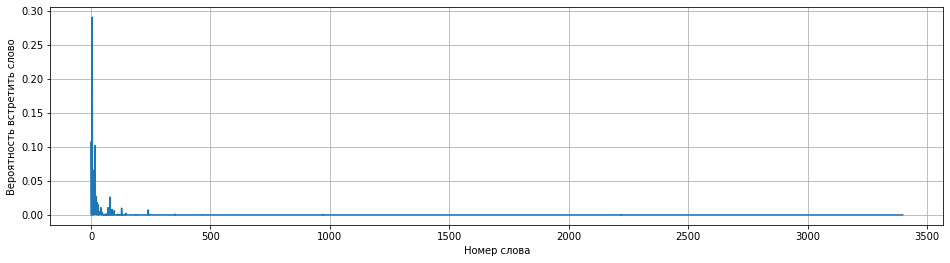

In [64]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])

plt.xlabel('Номер слова')
plt.ylabel('Вероятность встретить слово')

plt.grid()
plt.show()

In [65]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([ 1,  2,  5,  8, 15, 17])

In [66]:
for i,ind in enumerate(ind_prob.tolist()):
    print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

the  :  0.10774583
’  :  0.061057914
a  :  0.29076418
it  :  0.0661323
i  :  0.050467946
her  :  0.10190863
